# Series prediction 1

## Packages


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Data

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-03-01 08:58:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-03-01 08:58:15 (65.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

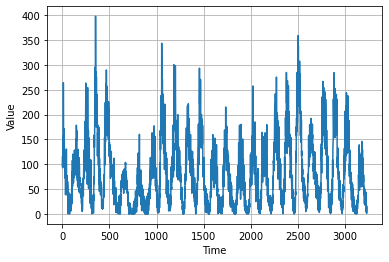

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
plot_series(time, series)

## Train and validation sets

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


## Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)


Epoch 1/200
30/30 [==============================] - 7s 120ms/step - loss: 42.6700 - mae: 43.1664
Epoch 2/200
30/30 [==============================] - 4s 116ms/step - loss: 23.2637 - mae: 23.7579
Epoch 3/200
30/30 [==============================] - 4s 120ms/step - loss: 19.7368 - mae: 20.2290
Epoch 4/200
30/30 [==============================] - 4s 116ms/step - loss: 19.0884 - mae: 19.5810
Epoch 5/200
30/30 [==============================] - 4s 118ms/step - loss: 18.3517 - mae: 18.8437
Epoch 6/200
30/30 [==============================] - 4s 117ms/step - loss: 18.6099 - mae: 19.1021
Epoch 7/200
30/30 [==============================] - 4s 117ms/step - loss: 17.9398 - mae: 18.4313
Epoch 8/200
30/30 [==============================] - 4s 117ms/step - loss: 18.3950 - mae: 18.8873
Epoch 9/200
30/30 [==============================] - 4s 117ms/step - loss: 17.6833 - mae: 18.1744
Epoch 10/200
30/30 [==============================] - 4s 118ms/step - loss: 17.5261 - mae: 18.0178
Epoch 11/200
30/30 

## Prediction

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(100).prefetch(1)
    forecast = model.predict(ds)
    return forecast

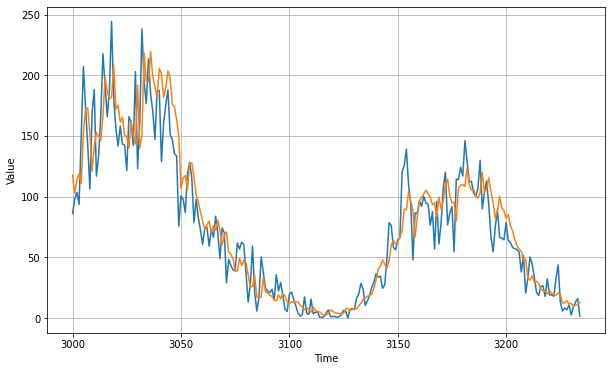

In [ ]:
window_size=60
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.203614